In [193]:
import math
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [194]:
from torch.autograd import Variable
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = Variable(torch.linspace(0, 1, 11))
# True function is sin(2*pi*x) with Gaussian noise N(0,0.04)
train_y = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)

from torch import optim
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable
from scipy.stats import norm
from scipy.optimize import minimize

In [195]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # Our mean function is constant in the interval [-1,1]
        self.mean_module = ConstantMean(constant_bounds=(-1, 1))
        # We use the RBF kernel as a universal approximator
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 5))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        # Return moddl output as GaussianRandomVariable
        return GaussianRandomVariable(mean_x, covar_x)

In [202]:
#Adaptation of acquisition maximization from Python BayesOpt implementation found at
#https://github.com/fmfn/BayesianOptimization

def acq_max(ac, gp, y_max, bounds, random_state, n_warmup=1000, n_iter=250):
    """
    A function to find the maximum of the acquisition function
    It uses a combination of random sampling (cheap) and the 'L-BFGS-B'
    optimization method. First by sampling `n_warmup` (1e5) points at random,
    and then running L-BFGS-B from `n_iter` (250) random starting points.
    Parameters
    ----------
    :param ac:
        The acquisition function object that return its point-wise value.
    :param gp:
        A gaussian process fitted to the relevant data.
    :param y_max:
        The current maximum known value of the target function.
    :param bounds:
        The variables bounds to limit the search of the acq max.
    :param random_state:
        instance of np.RandomState random number generator
    :param n_warmup:
        number of times to randomly sample the aquisition function
    :param n_iter:
        number of times to run scipy.minimize
    Returns
    -------
    :return: x_max, The arg max of the acquisition function.
    """
    
    # Warm up with random points
    x_tries = Variable(torch.from_numpy(random_state.uniform(bounds[0][0], bounds[0][1],
                                   size=n_warmup)).float())
    
    ys = ac(x_tries, gp=gp, y_max=y_max, xi=0.1)
    x_max = x_tries[ys.argmax()].data.numpy()
    max_acq = ys.max()

    # Explore the parameter space more throughly
    x_seeds = random_state.uniform(bounds[0][0], bounds[0][1],
                                   size=n_iter)
    for x_try in x_seeds:
        
        #x_try_torch = Variable(torch.from_numpy(np.array(x_try)).float())
        # Find the minimum of minus the acquisition function
        res = minimize(lambda x: -ac(Variable(torch.from_numpy(np.array(x)).float()), gp=gp, y_max=y_max, xi=0.1),
                       x_try.reshape(1, -1),
                       bounds=bounds,
                       method="L-BFGS-B")

        # See if success
        if not res.success:
            continue
           
        # Store it if better than previous minimum(maximum).
        if max_acq is None or -res.fun[0] >= max_acq:
            x_max = res.x
            max_acq = -res.fun[0]

    # Clip output to make sure it lies within the bounds. Due to floating
    # point technicalities this is not always the case.
    return np.clip(x_max, bounds[0][0], bounds[0][1])

In [203]:
class Bayes_opt:
    
    def __init__(self, func, step_num):
        
        self.step_num = step_num
        self.sample_pts = Variable(torch.zeros(step_num))     
        self.sample_vals = Variable(torch.zeros(step_num))       
        self.opt_val = float("inf")       
        self.opt_soln = None       
        self.obj_func = func
        self.model_GP = None
        
        
    def _ei(x, gp, y_max, xi):
    
        predict_pt = gp(x)
        mean = predict_pt.mean().data.numpy()
        std = torch.sqrt(predict_pt.var()).data.numpy()
        z = (mean - y_max - xi)/std
    
        return (mean - y_max - xi) * norm.cdf(z) + std * norm.pdf(z)
        
    
    def _update_GP(self, train_x, train_y):
        
        likelihood = GaussianLikelihood(log_noise_bounds=(-5, 5))
        
        model = ExactGPModel(train_x.data, train_y.data, likelihood)
        model.train()
        likelihood.train()
        
        # Use the adam optimizer
        optimizer = torch.optim.Adam([
            {'params': model.parameters()},  # Includes GaussianLikelihood parameters
        ], lr=0.1)

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        training_iter = 50
        for i in range(training_iter):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, train_y)
            loss.backward()
            #print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
                #i + 1, training_iter, loss.data[0],
                #model.covar_module.log_lengthscale.data[0, 0],
                #model.likelihood.log_noise.data[0]
            #))
            optimizer.step()
    
        # Put model and likelihood into eval mode
        model.eval()
        likelihood.eval()

        return model
        
        
    def optimize(self):
        
        start_pts = Variable(torch.rand(11))
        start_vals = Variable(start_pts.data.apply_(self.obj_func))

        self.model_GP = self._update_GP(start_pts, start_vals)
        
        print("GP initiated")
        
        for t in range(self.step_num):
            
            if t%10 == 9: print(t)
            
            new_pt = acq_max(ac=_ei, gp=self.model_GP, y_max=self.opt_val, bounds=[(0, 1)], random_state=np.random.RandomState())
            new_val = self.obj_func(new_pt)
            self.sample_pts[t] = float(new_pt)
            self.sample_vals[t] = float(new_val)
            
            if new_val < self.opt_val:
                self.opt_val = new_val 
                self.opt_soln = new_pt
                
            self.model_GP = self._update_GP(self.sample_pts[:t+1], self.sample_vals[:t+1])

In [207]:
#test _update_GP

def test_func(x): 
    return 1/(x+1)*np.cos(2*math.pi*x)

# Training data is 11 points in [0,1] inclusive regularly spaced
#train_x = Variable(torch.linspace(0, 1, 11))
train_x = Variable(torch.rand(11))
# True function is sin(2*pi*x) with Gaussian noise N(0,0.04)
train_y = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)

test = Bayes_opt(test_func, 20)

test.optimize()

#model = test._update_GP(x_np=train_x, y_np=train_y)

GP initiated


/home/sam/anaconda2/envs/gpytorch/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in multiply
/home/sam/anaconda2/envs/gpytorch/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


9
19


In [208]:
test.opt_val

array([0.3263587], dtype=float32)

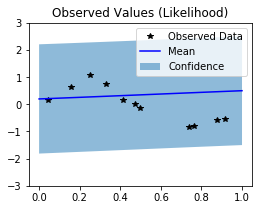

In [175]:
# Put model and likelihood into eval mode
model = test.model_GP

model.eval()
likelihood.eval()

# Initialize plot
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
# Test points are regularly spaced along [0,1] every 0.02
test_x = Variable(torch.linspace(0, 1, 51))
# Make predictions by feeding model through likelihood
with gpytorch.fast_pred_var():
    observed_pred = likelihood(model(test_x))

# Define plotting function
def ax_plot(ax, rand_var, title):
    
    rand_var = bayes_opt.model_GP
    train_x = bayes_opt.sample_pts
    train_y = bayes_opt.sample_vals
    
    # Get upper and lower confidence bounds
    lower, upper = rand_var.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    #Plot opt soln
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)
# Plot the predictions
ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')

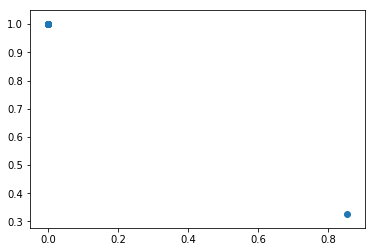

In [209]:
plt.scatter(test.sample_pts.data.numpy(), test.sample_vals.data.numpy())

In [211]:
test.sample_pts
test.sample_vals

Variable containing:
 0.3264
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
[torch.FloatTensor of size 20]